PASOS A SEGUIR EN ESTE TRABAJO:

OBJETIVO: Tratamos de encontrar aquel modelo que prediga mejor el número de visitas futuras a la página web de The Bridge.

1 - CARGA DE DATOS Y PREPARACIÓN INICIAL

 - Cargar librerías.
 - En database.py hemos creado las funciones para crear y actualizar la base de datos dsde un csv.
 - Formateo en entrenamiento.py de la columna fecha a objeto datetime.

In [39]:
# CARGAR LIBRERÍAS NECESARIAS.

import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

os.chdir(os.path.dirname(os.path.abspath('__file__')))

In [40]:
# cargar los datos de la db.
conn = sqlite3.connect('DB/daily_visits.db')
df = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date', index_col='Date')
conn.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851 entries, 2020-01-01 to 2022-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   851 non-null    int64
dtypes: int64(1)
memory usage: 13.3 KB


2 - ANÁLISIS EXPLORATORIO DE DATOS (EDA)

 - Visualizar serie temporal para comprender patrones y tendencias.
 - Identifica valores faltantes o Nans, outliers.
 - Analizar si la serie es estacionaria o no-estacionaria.
    Para ello hemos hecho uso de inspección visual de los gráficos, y de 2 test específicos para ello.

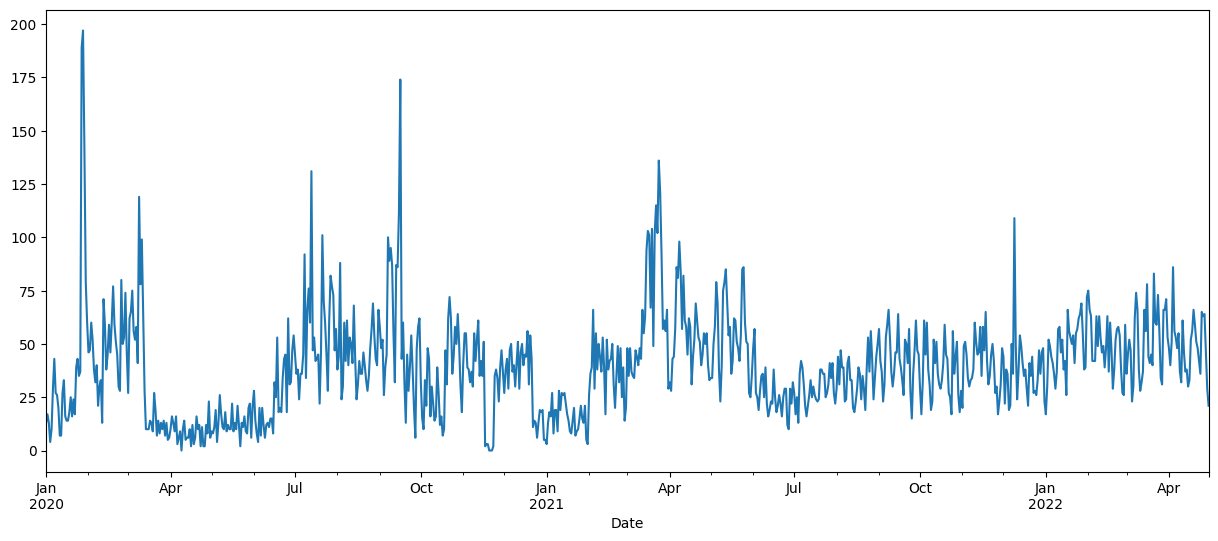

In [41]:
# grafico de la base de datos
df['Users'].plot(figsize=(15,6));
# se comprueba visualmente en la gráfica que hay una pequeña tendencia ascendente, y parece cíclico
# se comprueba que no hay fvalores nulos o Nans. 
# se comprueba que hay outliers, sobre en los primeros períodos de la serie temporal

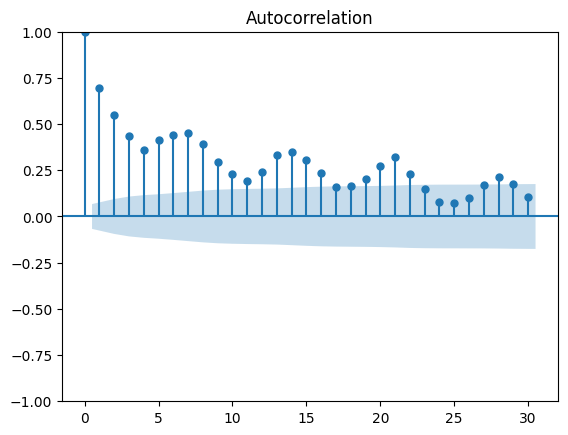

In [42]:
# grafico autocorrelaciones
plot_acf(df['Users']);
# Visualmente se ve que hay ciclos de de 7 días, y que la q del ARIMA podría ser 7

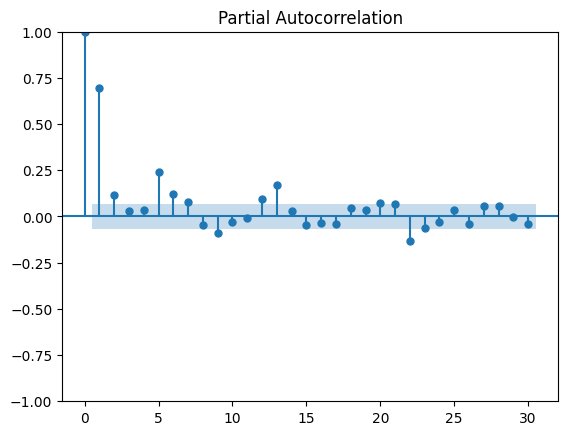

In [43]:
# grafico autocorrelacion parcial
plot_pacf(df['Users']);
# visualmente se ve que los datos están correlacionados con el período anterior, y que la p de ARIMA sería 2

In [47]:
# test Dickey Fuller, y graficos

def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [109]:
# prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss

# # Cargar tus datos desde el archivo CSV
# data = pd.read_csv('tu_archivo.csv')
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Realizar la prueba KPSS
result = kpss(df['Users'])

# Interpretar el resultado de la prueba
print("Prueba KPSS:")
print(f"Estadístico KPSS: {result[0]}")
print(f"P-valor: {result[1]}")
print("Lags utilizados: %s" % result[2])
print("Valores críticos:")
for key, value in result[3].items():
    print(f"  {key}: {value}")

# Interpretar el resultado de la prueba
if result[1] < 0.05:
    print("La serie de tiempo no es estacionaria (rechaza la hipótesis nula)")
else:
    print("La serie de tiempo es estacionaria (no rechaza la hipótesis nula)")

# este test se comporta a la inversa que el anterior, esto es, el P-Valor el mayor que el umbral 0.05
# significa que no se rechaza la H0 o hipótesis nula de que la serie temporal es estacionaria

Prueba KPSS:
Estadístico KPSS: 0.4168264621164197
P-valor: 0.06990238701878461
Lags utilizados: 15
Valores críticos:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
La serie de tiempo es estacionaria (no rechaza la hipótesis nula)


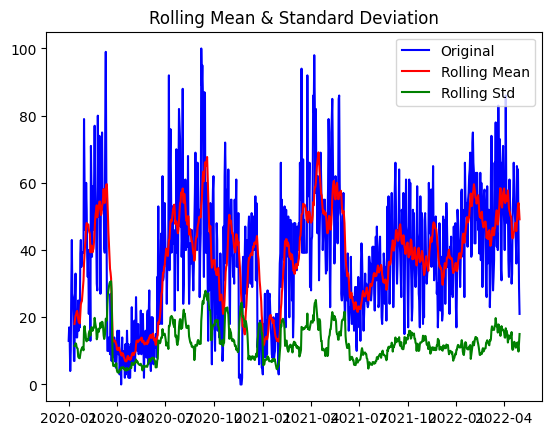

Results of Dickey Fuller Test:
Test Statistic                  -3.326740
p-value                          0.013725
#Lags Used                      20.000000
Number of Observations Used    830.000000
Critical Value (1%)             -3.438253
Critical Value (5%)             -2.865029
Critical Value (10%)            -2.568628
dtype: float64


In [48]:
test_stationarity(df)
# En el gráfico se ve que la media y desviación estándar con constantes en el tiempo
# El resultado del test indica es estacionaria, porque el P-Valor es menor a 0.05.
# Lo que significa que se rechaza la hipótesis nula H0 de si la serie temporal es no-estacionaria

In [44]:
# ver valores de los outliers
df[df['Users'].values > 100]

,Users
Date,
2020-01-27,189
2020-01-28,197
2020-01-29,142
2020-03-09,119
2020-07-13,131
2020-07-21,101
2020-09-15,112
2020-09-16,174
2021-03-16,103


In [45]:
# sustituir outliers por media
df['Users'] = df['Users'].apply(lambda x: df['Users'].mean() if (x > 100) else x)

3 - PREPROCESAMIENTO DE DATOS

 - Rellena o interpola valores faltantes, si es necesario. No es necesario.
 - Realiza transformaciones como suavizado, diferenciación y normalización, según sea necesario para hacer que la serie temporal sea estacionaria y tenga propiedades deseables para el modelo. 
    Que se realiza una transformación logarítmica antes de probar el modelo ARIMA.
    Se hace smoothing también para suavizar la gráfica. 
    Se realiza la descomposición en los componentes básicos de la serie de temporal en la aplicación de otro modelo.
    También se buscan los valores adecuados de p, q y d para el modelo en concreto. 

4 - SELECCIÓN DEL MODELO.

 - Hemos hecho una función para ver qué configurción de ARIMA es la mejor. 
 - También hemos hecho de la función Auto-ARIMA para ver qué hiperparámetros son los más adecuados.
 - Hemos probado diferentes modelos de regresión de series temporales.

In [46]:
# probar difs arimas de 1 en 1, pq el auto-arima a veces se para antes
def best_arima(train, predict_n, d):
    p = q = range(1, 10)
    best_mape = 1
    best_p = best_q = 0
    for i in p:
        for j in q:
            model = ARIMA(order=(i, d, j))
            model_fit = model.fit(train)
            predictions = model_fit.predict(predict_n)
            mape = mean_absolute_percentage_error(test, predictions)
            if mape < best_mape:
                best_p = i
                best_q = j
                best_mape = mape
    print(best_p, best_q, best_mape)

5 - DIVISIÓN DE DATOS

 - Hemos dividido la serie temporal en conjuntos de entrenamiento y prueba, antes de entrenar los modelos.
    Este proceso se lleva a cabo dentro de la aplicación de cada modelo.

In [50]:
# división del conjunto de datos entre datos de entrenamiento o train, y datos de prueba o test
X = df['Users'].values
train = X[:int(len(X)*0.95)]
test = X[int(len(X)*0.95):]
print(len(X), len(train) + len(test))

851 851


In [51]:
# ver número de elementos en el conjunto de prueba o test
len(test)

43

6 - ENTRENAMIENTO DEL MODELO

 - Los modelos se han entrenado, usando las librerías correspondientes.
    Este proceso se lleva a cabo dentro de la aplicación de cada modelo.

7 - VALIDACIÓN Y AJUSTE DE LOS MODELOS

 - Hemos usado la métrica MAPE para evaluar el rendimiento de los modelos.
 - Los hiperparámetros se han ajustado, haciendo uso, tanto de la función antes creada best-arima, como de la función Auto_ARIMA, como un análisis exhaustivo para determinar los valores óptimos de p, q y d.
    Estos procesos se llevan a cabo dentro de la aplicación de cada modelo.

In [52]:
model_ar = best_arima(train, len(test), 1)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

9 5 0.18066492773743556


8 - PREDICCIONES Y EVALUACIÓN FINAL

 - Las prediciiones se han llevado a cabo dentro de la aplicación de cada modelo.
 - Se han creado los gráficos correspondientes para evaluar la predicción del modelo.
 - Nos hemos basado en el menor resultado de la métrica MAPE para elegir aquel modelo que va a servir para predecir el número de visitas futuras a la web The Bridge.

--------------------------------------------------------------------------------------------------------------------------------------------

1er MODELO: ARIMA SEGÚN LOS RESULTADOS DE LA FUNCIÓN BEST-ARIMA

In [53]:
# elección del mejor modelo según los resultados de la función best_arima
model = ARIMA(order=(9, 1, 5)) # 95% de data mape 0.18
model_ar = model.fit(train)

predictions = model_ar.predict(len(test))
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))
# RESULTADOS SUFICIENTES, PERO NO SE PUEDEN MEJORAR

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 8.814315739811244
MAPE: 0.18066492773743556


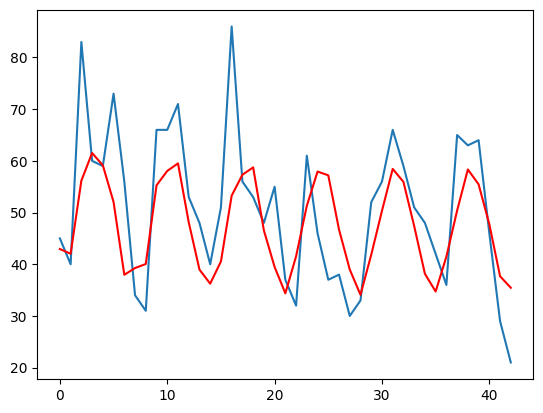

In [54]:
# gráfico de las predicciones del BEST ARIMA
plt.plot(test)
plt.plot(predictions,color='red');

2º MODELO: ARIMA CON TRANSFORMACIÓN LOGARÍTMICA PREVIA

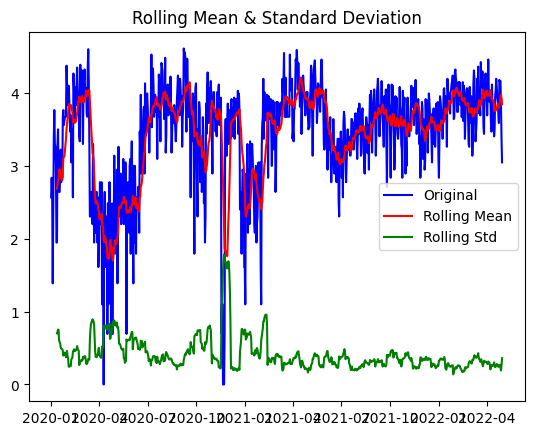

Results of Dickey Fuller Test:
Test Statistic                  -3.214690
p-value                          0.019150
#Lags Used                      21.000000
Number of Observations Used    829.000000
Critical Value (1%)             -3.438263
Critical Value (5%)             -2.865033
Critical Value (10%)            -2.568630
dtype: float64


In [56]:
# transformación logarítmica
df_logScale = np.log(df)

# quitar los -infinitos de la serie
df_logScale[df_logScale.index.isin(np.isfinite(df_logScale[['Users']]).query('not Users').index)] = 0

# gráfico para comprobar la estacionariedad
test_stationarity(df_logScale)
# el P-Valor sigue refutando la hipótesis nula H0 de que la serie es no-estacionaria

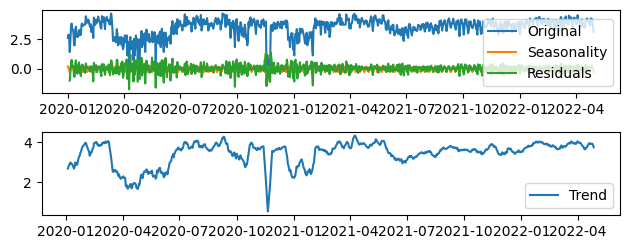

In [57]:
# se realiza la descomposición de la serie temporal con los valores transformados de forma logarítmica en sus componentes esenciales
# los componentes esenciales son la tendencia, la seasonalidad o estacionalidad, y el error o residuos (parte aleatoria)
decomposition = seasonal_decompose(df_logScale)

trend = decomposition.trend # tendencia
seasonal = decomposition.seasonal # seasonalidad
residual = decomposition.resid # errores o residuos

# se grafican los componentes
plt.subplot(411)
plt.plot(df_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

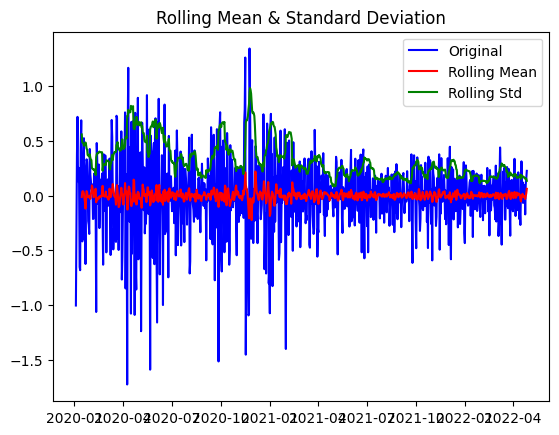

Results of Dickey Fuller Test:
Test Statistic                -1.288813e+01
p-value                        4.508296e-24
#Lags Used                     1.900000e+01
Number of Observations Used    8.250000e+02
Critical Value (1%)           -3.438301e+00
Critical Value (5%)           -2.865050e+00
Critical Value (10%)          -2.568639e+00
dtype: float64


In [58]:
# Compruebo con la data residual si la serie es estacionaria
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

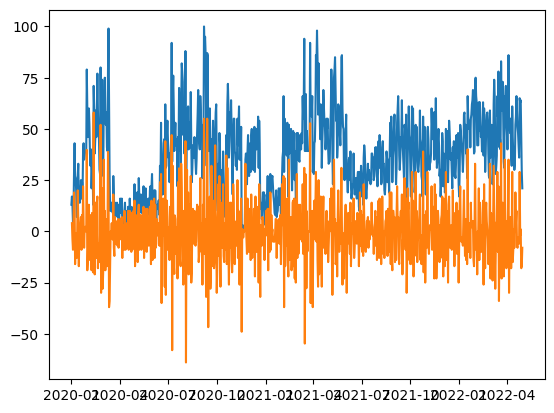

In [59]:
# probar la diferencia entre d=1 o d=0 para luego aplicarlo en el modelo ARIMA
# d se refiere a la necesidad de diferenciación o no, para convertir la serie es estacionaria
plt.plot(df)
plt.plot(df.diff())

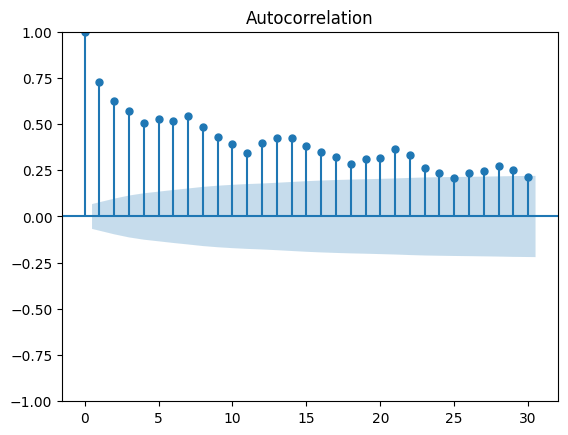

In [60]:
# ploteo para calcular visualmente q u orden del componente de media móvil del modelo ARIMA
# q representa el número de términos de rezago de la serie de errores que se incluyen en el modelo
plot_acf(df_logScale['Users'].dropna()); 
# q = 25 errores

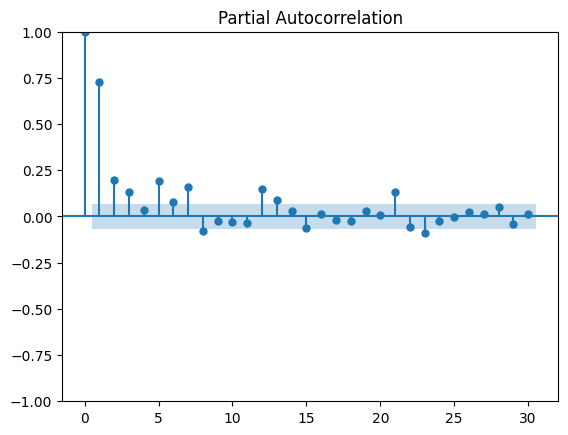

In [61]:
# ploteo para calcular visualmente p u orden del componente autorregresivo
plot_pacf(df_logScale['Users'].dropna()); 
# p = 2 lags

In [62]:
# dividimos conjunto de datos en train y test
X = df_logScale['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


In [63]:
# número de elementos en el conjunto de datos test
len(test)

128

In [32]:
# entrenamiento del modelo ARIMA
model_ar = ARIMA(order=(2, 1, 25))
model_ar.fit(train)

# prediciones del modelo
predictions_log = model_ar.predict(128)

# métrica de evauación del modelo
print("MAE:", mean_absolute_error(test, predictions_log))
print("MAPE:", mean_absolute_percentage_error(test, predictions_log))

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.2668770242666658
MAPE: 0.06965123805983614


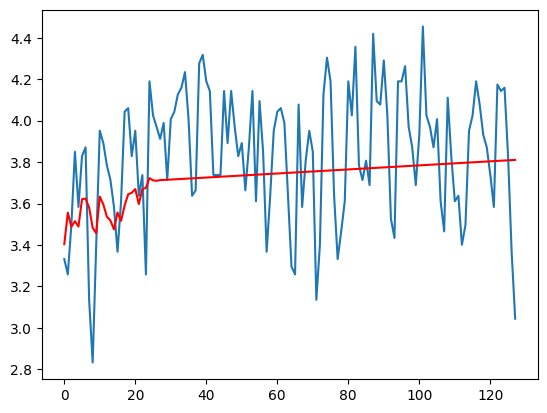

In [33]:
# grafico que muestra la linea de roja regresion (predicción), frente a la data real en azul
plt.plot(test)
plt.plot(predictions_log,color='red');

In [86]:
# se aplica la función best-arima para ajustar los hiperparámetros
best_arima(train, 128, 1)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

In [64]:
# usamos los mejores hiperparametros del resultado de la función anterior
model = ARIMA(order=(9, 1, 6)) # 9,1,6
model.fit(train)

predictions_log = model.predict(128)
print("MAE:", mean_absolute_error(test, predictions_log))
print("MAPE:", mean_absolute_percentage_error(test, predictions_log))
# ESTE MODELO DA EL MEJOR RESULTADO

MAE: 0.24205398839837777
MAPE: 0.06255675671469522


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


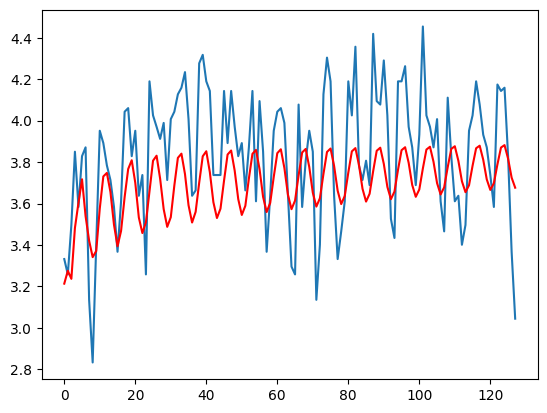

In [65]:
# ploteamos la predicción con los nuevos hiperparametros
plt.plot(test)
plt.plot(predictions_log,color='red');

In [66]:
# hacemos la transformación inversa a la logarítmica, esto es, la exponencial
# lo hacemos para que nos de lo resultados de número de visitas en datos reales, no logarítmicos
predictions_log = pd.DataFrame(data=predictions_log, index=df.iloc[int(len(X)*0.85):].index, columns=['Users'])
predictions = np.exp(predictions_log)
print(predictions)

                Users
Date                 
2021-12-24  24.867232
2021-12-25  26.461535
2021-12-26  25.451967
2021-12-27  32.525885
2021-12-28  36.734664
...               ...
2022-04-26  47.950962
2022-04-27  48.517230
2022-04-28  45.455457
2022-04-29  41.471971
2022-04-30  39.508073

[128 rows x 1 columns]


3er MODELO: ARIMA CON SMOOTHING

In [67]:
conn = sqlite3.connect('DB/daily_visits.db')
df = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date', index_col='Date')
conn.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851 entries, 2020-01-01 to 2022-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   851 non-null    int64
dtypes: int64(1)
memory usage: 13.3 KB


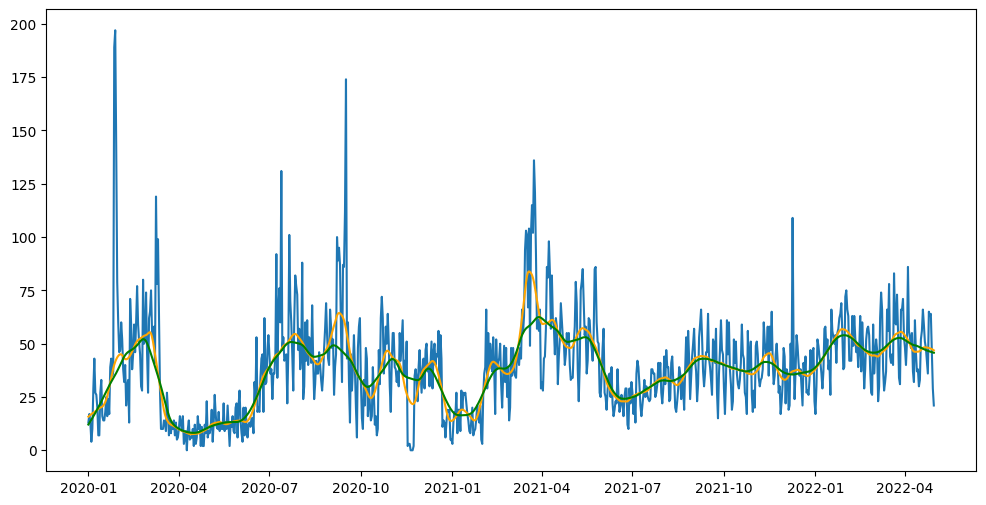

In [68]:
# realizo el suavizado con 2 valores diferentes en el hiperparámetro frac
from statsmodels.nonparametric.smoothers_lowess import lowess

df_loess_3 = pd.DataFrame(lowess(df['Users'], np.arange(len(df['Users'])), frac=0.03)[:, 1], index=df.index, columns=['Users'])
df_loess_5 = pd.DataFrame(lowess(df['Users'], np.arange(len(df['Users'])), frac=0.05)[:, 1], index=df.index, columns=['Users'])

# ploteo la data real en comparación con esos 2 valores
plt.figure(figsize=(12, 6))
plt.plot(df['Users'])
plt.plot(df_loess_3, color='orange')
plt.plot(df_loess_5, color='green')

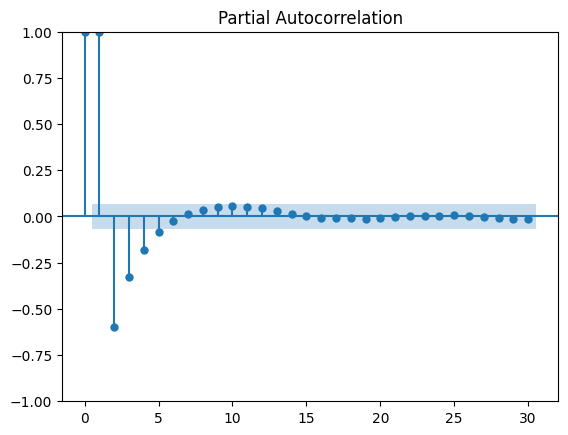

In [69]:
# ploteo para visualizar el mejor valor de d. d=1
plot_pacf(df_loess_3['Users'].dropna());

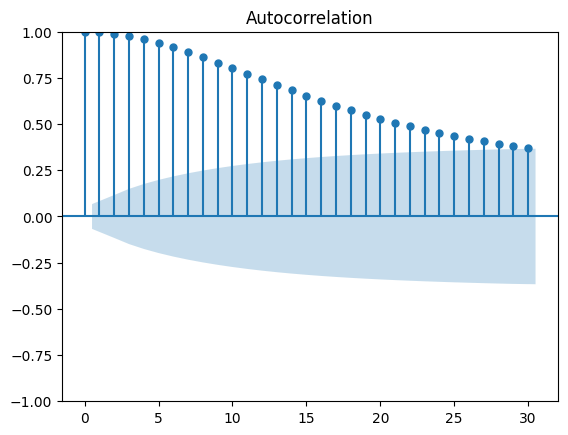

In [70]:
# ploteo la autocorrelación
plot_acf(df_loess_3['Users'].dropna());

In [71]:
# divido conjunto de datos en train y test
X = df_loess_3['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


In [72]:
# número de elementos en conjunto test
len(test)

128

In [73]:
# implemento modelo Auto-ARIMA para encontrar mejores valores en hiperparámetros
model = auto_arima(train,
                   start_p = 5,
                   start_q = 5,
                   max_p = 15,
                   max_q = 15,
                   d = 1,
                   m=7,
                   trace=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(5,1,5)(1,0,1)[7] intercept   : AIC=-2262.390, Time=8.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2168.787, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-145.578, Time=1.00 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=830.804, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2167.222, Time=0.03 sec
 ARIMA(5,1,5)(0,0,1)[7] intercept   : AIC=-2270.557, Time=8.06 sec
 ARIMA(5,1,5)(0,0,0)[7] intercept   : AIC=-2227.675, Time=5.27 sec
 ARIMA(5,1,5)(0,0,2)[7] intercept   : AIC=-2268.398, Time=14.70 sec
 ARIMA(5,1,5)(1,0,0)[7] intercept   : AIC=-2261.921, Time=7.92 sec
 ARIMA(5,1,5)(1,0,2)[7] intercept   : AIC=-2265.946, Time=14.54 sec
 ARIMA(4,1,5)(0,0,1)[7] intercept   : AIC=-2271.019, Time=5.41 sec
 ARIMA(4,1,5)(0,0,0)[7] intercept   : AIC=-2270.405, Time=3.37 sec
 ARIMA(4,1,5)(1,0,1)[7] intercept   : AIC=-2268.632, Time=7.25 sec
 ARIMA(4,1,5)(0,0,2)[7] intercept   : AIC=-2270.759, Time=11.76 sec
 ARIMA(4,1,5)(1,0,0)[

MAE: 11.490724179542742
MAPE: 0.22892388502585512


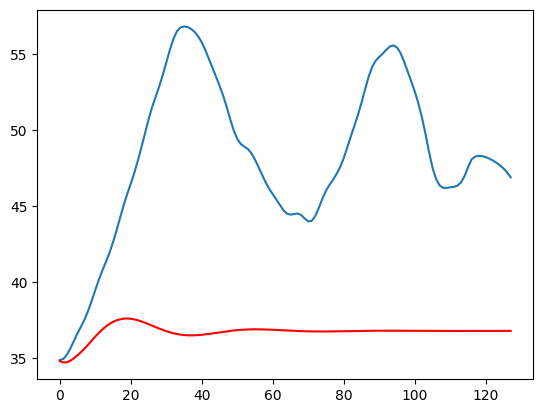

In [74]:
# entrenamiento con el mejor modelo de Auto-ARIMA
model_fit = model.fit(train)

# predicciones
predictions = model_fit.predict(128)

# evaluación
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

# ploteo predicciones
plt.plot(test)
plt.plot(predictions,color='red');

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 6.201840564374537
MAPE: 0.1232930529943144


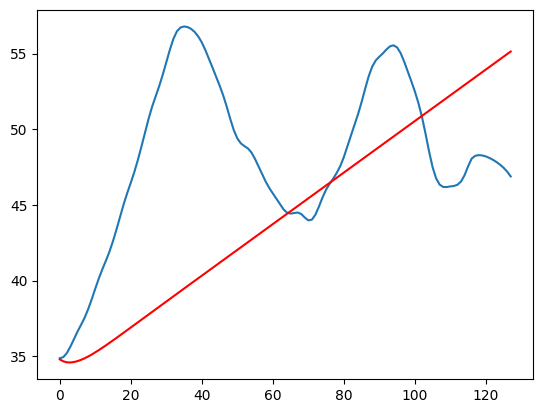

In [75]:
# prueba con otros valores
model = ARIMA(order=(7, 1, 5))

# entrenamiento con el mejor modelo de Auto-ARIMA
model_fit = model.fit(train)

# predicciones
predictions = model_fit.predict(128)

# evaluación
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))
# DA BUENOS RESULTADOS

# ploteo predicciones
plt.plot(test)
plt.plot(predictions,color='red');

4º MODELO: ARIMA CON XGBOOST

In [76]:
# cargar los datos de la base de datos
conn = sqlite3.connect('DB/daily_visits.db')
df2 = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date')
conn.close() # cerrar conexión
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    851 non-null    datetime64[ns]
 1   Users   851 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


In [78]:
# Calcular los percentiles para identificar outliers
percentile_25 = np.percentile(df2['Users'], 25)
percentile_75 = np.percentile(df2['Users'], 75)
iqr = percentile_75 - percentile_25
lower_threshold = percentile_25 - 1.5 * iqr
upper_threshold = percentile_75 + 1.5 * iqr

# Filtrar los outliers
filtered_df2 = df2[(df2['Users'] >= lower_threshold) & (df2['Users'] <= upper_threshold)]

In [79]:
# # sustituir outliers por media
# df2['Users'] = df2['Users'].apply(lambda x: df2['Users'].mean() if (x > 100) else x)
# no cambia el resultado MAPE

In [80]:
# quitar 0s
df2['Users'] = df2['Users'].apply(lambda x: max(x, 1))

<Axes: xlabel='Weekday'>

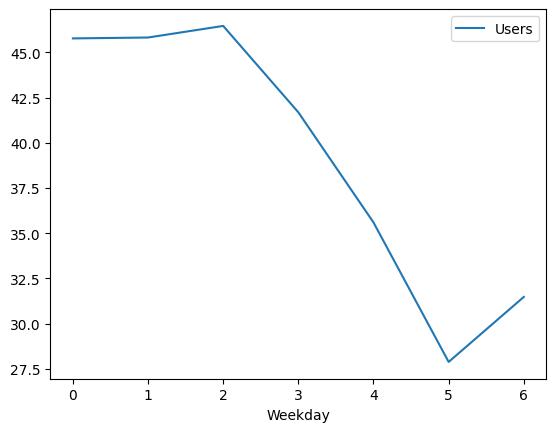

In [81]:
# hacer una columna dias de la semana, j, v y s bajan visitas
df2['Weekday'] = df2['Date'].dt.weekday
df2.groupby('Weekday')[['Users']].mean().plot() # jueves viernes y sabado hay menos visitas

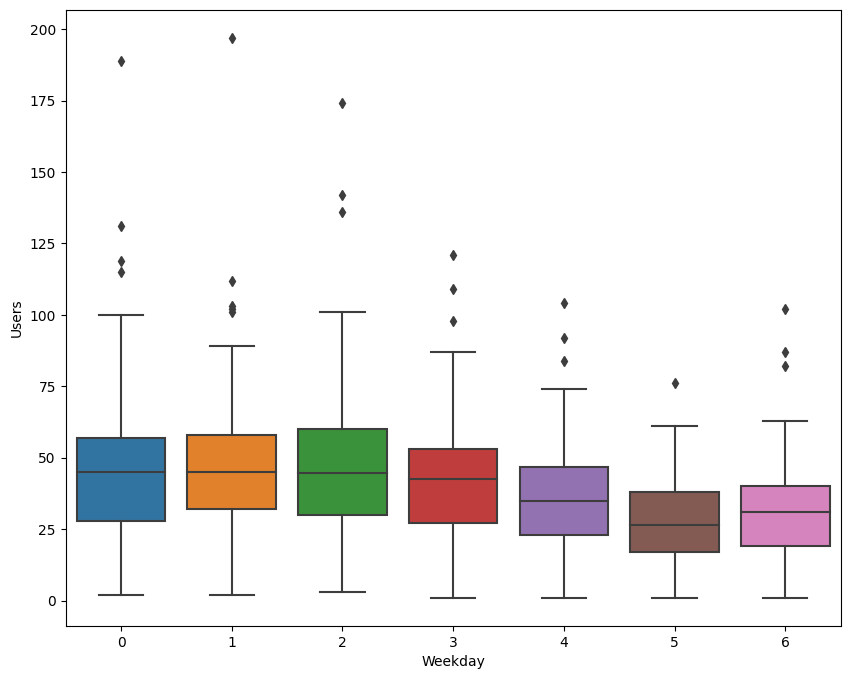

In [82]:
# lo mismo, se ven outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='Weekday', y='Users')
plt.show()

<Axes: xlabel='Month'>

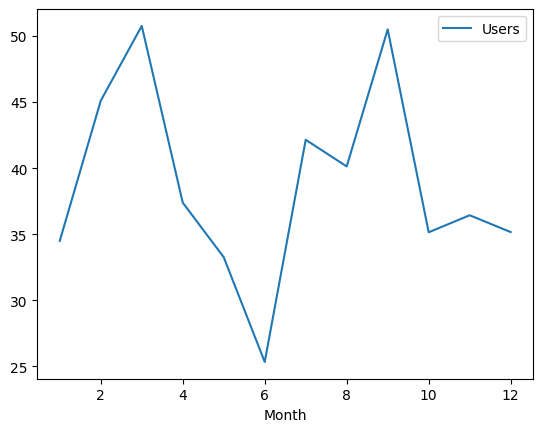

In [86]:
# lo mismo en meses, en verano y en invierno hay menos visitas
df2['Month'] = df2['Date'].dt.month
df2.groupby('Month')[['Users']].mean().plot() # en verano y navidad hay menos

In [87]:
# para sacar boxplot de abajo
df2.groupby('Month')[['Date', 'Users']].mean()

,Date,Users
Month,,
1,2021-01-15 16:00:00.000000000,34.494624
2,2021-02-10 00:50:49.411764736,45.105882
3,2021-03-16 00:00:00.000000000,50.763441
4,2021-04-15 12:00:00.000000000,37.388889
5,2020-11-14 12:00:00.000000000,33.258065
6,2020-12-15 00:00:00.000000000,25.333333
7,2021-01-14 12:00:00.000000000,42.145161
8,2021-02-14 12:00:00.000000000,40.129032
9,2021-03-17 00:00:00.000000000,50.500000


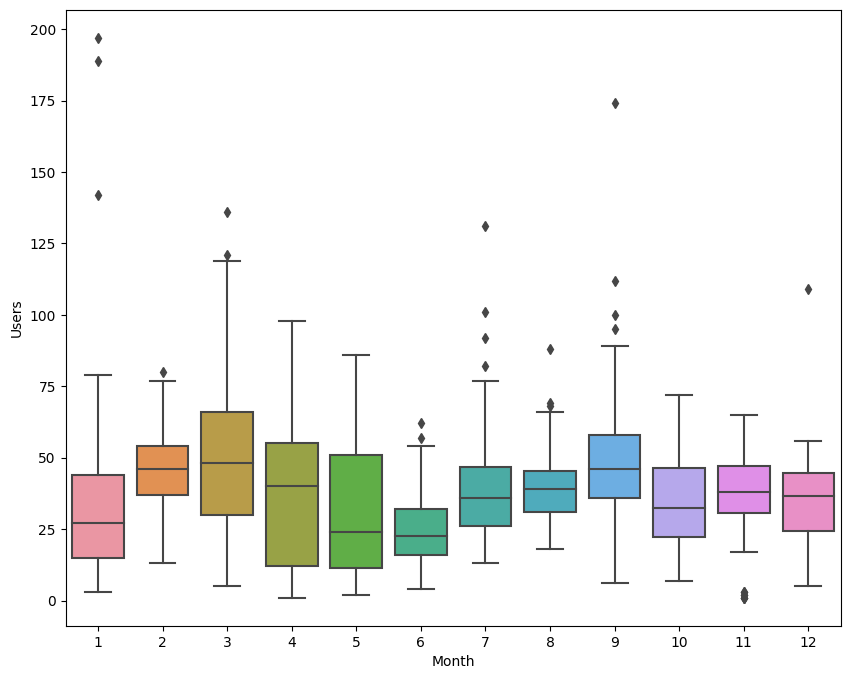

In [88]:
# graf meses, ver tendencia de meses
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='Month', y='Users')
plt.show()

<Axes: xlabel='Day'>

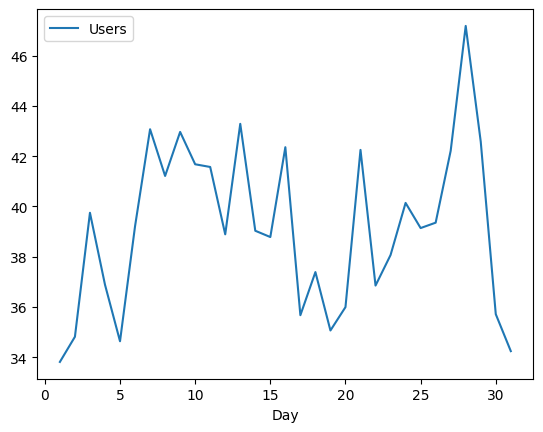

In [89]:
# se ven los dias del mes, no hay mucha info
df2['Day'] = df2['Date'].dt.day
df2.groupby('Day')[['Users']].mean().plot()

In [90]:
from sklearn.model_selection import train_test_split

X = df2[['Weekday', 'Month']] # .iloc[518:]
y = df2['Users']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 12)

In [92]:
import xgboost as xgb

# implementar modelo XgBoost
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01)
# entrenamiento
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[08:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:45.10074	validation_1-rmse:44.01016


[100]	validation_0-rmse:26.03593	validation_1-rmse:25.55620
[200]	validation_0-rmse:21.97157	validation_1-rmse:21.63459
[300]	validation_0-rmse:21.23668	validation_1-rmse:21.07055
[389]	validation_0-rmse:21.08781	validation_1-rmse:21.09704


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

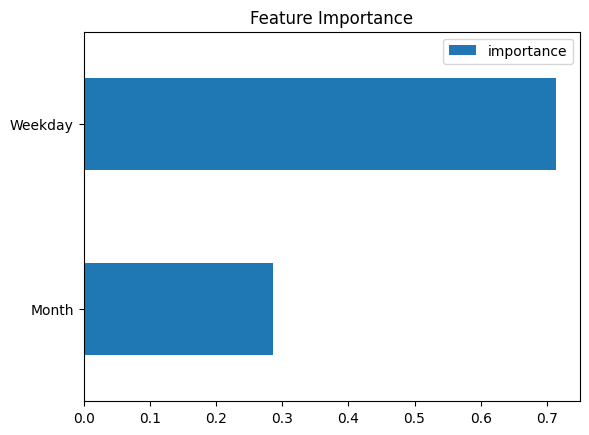

In [36]:
# vemos el feature-importance de los días de la semana y del mes
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


In [93]:
# predicciones XgBoost
predictions = reg.predict(X_test)

# evaluación
print("MAE:", mean_absolute_error(y_test, predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, predictions))

MAE: 15.307219997048378
MAPE: 0.8929592583306452


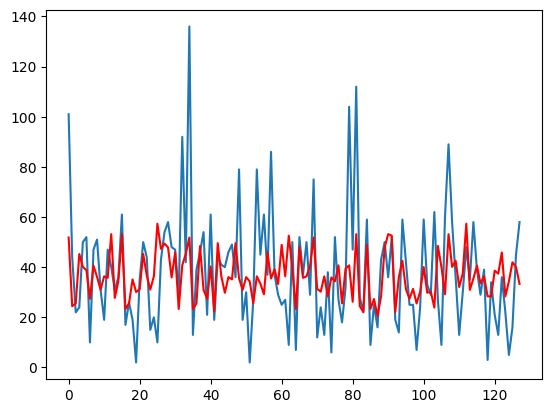

In [94]:
# ploteamos resultados de la predicción frente a la data real
plt.plot(y_test.values)
plt.plot(predictions,color='red');

5º MODELO: ARIMA

In [96]:
# cargar los datos de la base de datos
conn = sqlite3.connect('DB/daily_visits.db')
df2 = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date')
conn.close() # cerrar conexión
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    851 non-null    datetime64[ns]
 1   Users   851 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


In [97]:
# dividir conjunto de datos en train y test
X = df['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


In [98]:
# implementar y entrenar modelo ARIMA
model_ar = ARIMA(order=(1,0,0))
model_ar.fit(train)

ARIMA(order=(1, 0, 0))

In [99]:
# predicciones y evaluación
predictions = model_ar.predict(128)
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

MAE: 14.207949691824439
MAPE: 0.2738329129813823


In [100]:
# probar otros hiperparámetros
model = ARIMA(order=(5, 0, 5))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  723
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -3030.391
Date:                Fri, 01 Sep 2023   AIC                           6084.783
Time:                        08:41:40   BIC                           6139.784
Sample:                             0   HQIC                          6106.012
                                - 723                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9631      2.537      2.745      0.006       1.991      11.935
ar.L1          0.6741      0.044     15.264      0.000       0.588       0.761
ar.L2          0.1427      0.061      2.345      0.0

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
# predicciones y evaluación
predictions = model.predict(128)
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

MAE: 15.152774555019942
MAPE: 0.28285149959596545


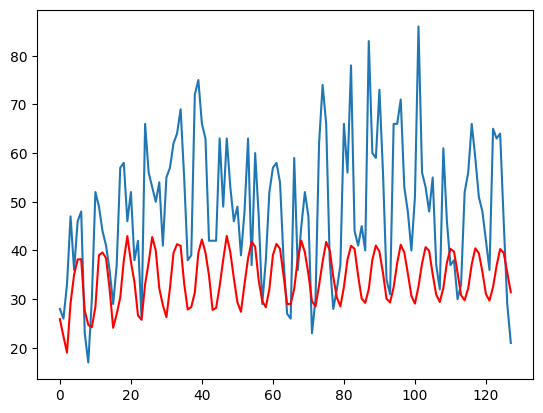

In [102]:
# gráfico de resultados de la predicción
plt.plot(test)
plt.plot(predictions,color='red');

6º MODELO: ARIMA CON SMOOTHING O SUAVIZADO EXPONENCIAL, Y DESCOMPOSICIÓN DE LA SERIE

In [103]:
# cargar los datos de la base de datos
conn = sqlite3.connect('DB/daily_visits.db')
df2 = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date')
conn.close() # cerrar conexión
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    851 non-null    datetime64[ns]
 1   Users   851 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


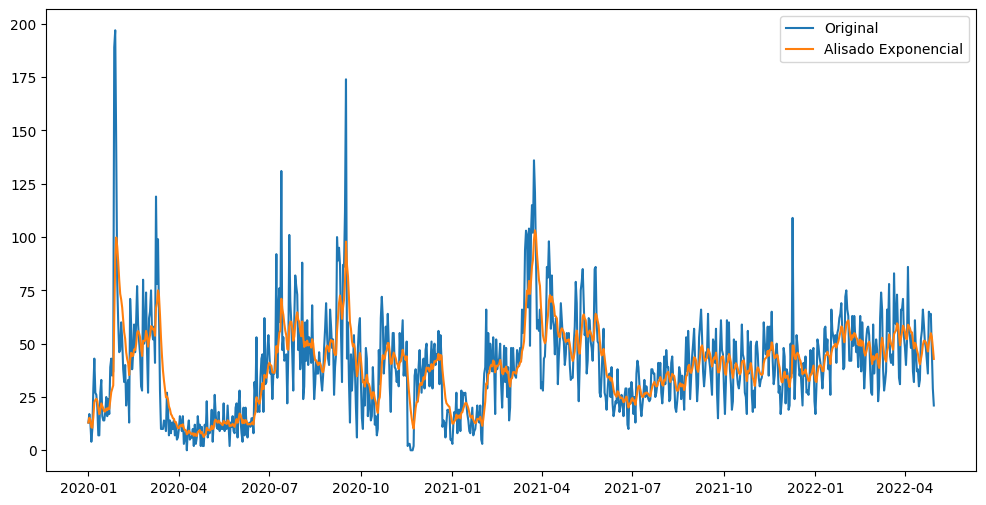

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Aplicar alisado exponencial utilizando la función rolling() de pandas
alpha = 0.2  # Factor de suavizado
smoothed_data = df['Users'].ewm(alpha=alpha).mean()

# Visualizar la serie de tiempo original y el alisado exponencial
plt.figure(figsize=(12, 6))
plt.plot(df['Users'], label='Original')
plt.plot(smoothed_data, label='Alisado Exponencial')
plt.legend()
plt.show()

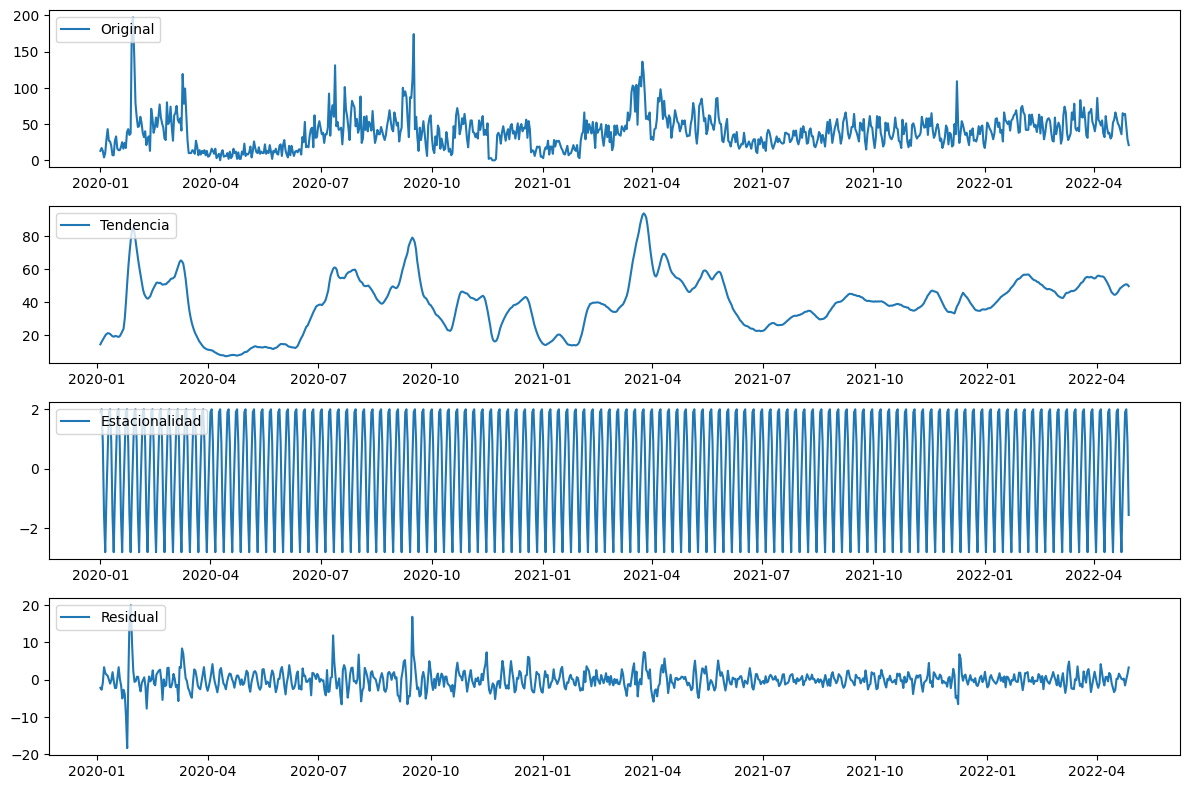

In [105]:
# Aplicar la descomposición con smoothing 
decomposition = seasonal_decompose(smoothed_data, model='additive')  # Puedes usar 'additive' en lugar de 'multiplicative'

# Obtener las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualizar las componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Users'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Rellenar valores NaN en la serie de tiempo residual utilizando interpolación lineal
residual = residual.interpolate()

In [106]:
# dividir conjunto de datos en train y test
X = df['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


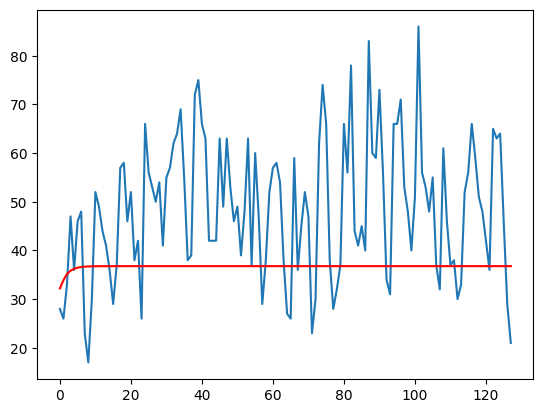

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Ajustar un modelo ARIMA a la serie de tiempo residual
model = ARIMA(train, order=(2, 1, 2))  # Orden (p, d, q)
results = model.fit()

# Realizar predicciones utilizando el modelo ajustado
forecast_steps = len(test)  # Por ejemplo, 7 días de predicción
forecast = results.forecast(steps=forecast_steps)

plt.plot(test)
plt.plot(forecast, color='red');

In [108]:
# Calcular el MAPE entre las predicciones y los valores reales de la serie residual
actual_residuals = test[-forecast_steps:]
mape = mean_absolute_percentage_error(actual_residuals, forecast)
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")

Error Porcentual Absoluto Medio (MAPE): 0.28%


7º MODELO: PROPHET

In [111]:
# cargar los datos de la base de datos
conn = sqlite3.connect('DB/daily_visits.db')
df2 = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date')
conn.close() # cerrar conexión
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    851 non-null    datetime64[ns]
 1   Users   851 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


In [114]:
# Resetear el índice y convertir "Date" en una columna
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

09:01:53 - cmdstanpy - INFO - Chain [1] start processing
09:01:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 533974108678106.25


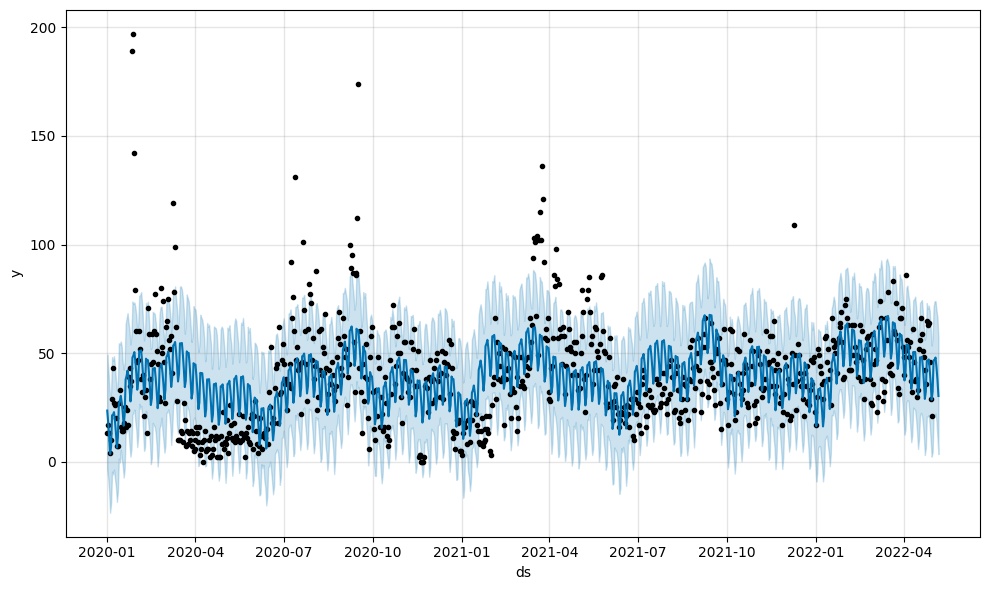

In [115]:
import pandas as pd
from prophet import Prophet

# Renombrar las columnas para que coincidan con los requisitos de Prophet
df.rename(columns={'Date': 'ds', 'Users': 'y'}, inplace=True)

# Crear un objeto Prophet y ajustarlo a los datos
model = Prophet()
model.fit(df)

# Crear un DataFrame para las fechas futuras a pronosticar
future = model.make_future_dataframe(periods=7)  # Por ejemplo, 7 días de pronóstico

# Realizar el pronóstico
forecast = model.predict(future)

# Visualizar el pronóstico y los componentes
fig = model.plot(forecast)

# Obtener las predicciones y valores reales
forecast_values = forecast['yhat'][:-7]  # Excluir las fechas futuras
actual_values = df['y']

# Calcular el MAPE utilizando sklearn.metrics.mean_absolute_percentage_error
mape = mean_absolute_percentage_error(actual_values, forecast_values)

print("MAPE:", mape)

In [ ]:
# graficamos las predicciones en comparación con la data real de test
plt.plot(actual_values)
plt.plot(forecast_values, color="red")